In [1]:
%pip install scikit-learn
# %pip install tqdm
# %pip install torch
# %pip install spacy
# %pip install gensim
# !pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1.tar.gz

In [2]:
import spacy

nlp = spacy.load("en_core_web_sm")

def spacy_process(text):
    doc = nlp(text)

    filtered_sentence = [
        token.lemma_ for token in doc
        if not token.is_stop and token.lemma_ not in "?:!.,;' ()\"/123456789"
    ]

    return filtered_sentence

In [4]:
import json
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

# f = open('./data (2).json', 'r')
f = open('./prdata.json', "r")
interview_data = json.load(f)
f.close()

total = []
total_t = []
for x in range(425):
    for y in range(10):
        total_t.append(interview_data[str(x) + ',' + str(y)])
        total += interview_data[str(x) + ',' + str(y)]

# t = []
# for x in total:
#     t += x.replace("!", ".").replace("?", ".").split(".")
# print(len(t))
print(total_t[0])

['On February 19, in Brasília, political consultations between the Ministries of Foreign Affairs of the Republic of Armenia and the Federal Republic of Brazil took place. The consultations were held by Paruyr Hovhannisyan, Deputy Minister of Foreign Affairs of Armenia and Maria Laura da Rocha, Secretary-General of the Ministry of Foreign Affairs of Brazil.', 'The parties discussed issues on bilateral agenda, emphasized mutual willingness to intensify the Armenian-Brazilian political dialogue, expand the legal framework, and further develop inter-parliamentary, trade and economic ties.', 'The interlocutors touched upon the cooperation within the framework of international organizations, stressing the importance of regular consultations between the Ministries of the two countries.', 'During the meeting, regional transport and economic projects were touched upon. In this context, Deputy Minister Paruyr Hovhannisyan presented the «Crossroads of Peace» initiative developed by the Government

In [5]:
from tqdm import tqdm


file_list = []
for text in tqdm(total):
  for sentence in text.split('.'):
    file_list.append(spacy_process(sentence))


with open('./sampled_data.json','w') as f:
  json.dump(file_list, f)

100%|██████████| 19854/19854 [08:36<00:00, 38.46it/s]


In [6]:
model = Word2Vec(sentences=file_list, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [7]:
import numpy as np

def word_similarity(a, b):
  return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [8]:

list_of_anxious_words_in_text = [
    "conflict", "Artsakh",
]

anxious_vector = np.mean(np.array([
    model.wv[word] for word in list_of_anxious_words_in_text
]), axis=0)

word_similarity(model.wv['Armenia'], model.wv['World'])

-0.17341149

In [9]:
# Here we import the correlation data
import numpy as np


def calculate_vector(sentence):
    return np.mean(np.array([
        model.wv[word] for word in spacy_process(sentence)
    ]), axis=0)


def get_dataset(testing=False):
    dataset = []
    skipped = 0
    with open("coded.txt", "r") as f:
        data = f.readlines()
        for line in data:
            index, status = line.split(":")
            status = status.replace(" ", "").replace("\n", "")
            doc, sentence_index = index.split(",")
            try:
                sentence = total[int(doc)].replace("?", ".").replace("!", ".").split(".")[int(sentence_index)]
                if sentence == "" or sentence == " ":
                    skipped += 1
                    continue

                if not testing:
                    if status == "Y":
                        dataset.append((torch.from_numpy(calculate_vector(sentence)), torch.Tensor([1, 0])))
                    elif status == "V" or status == "N":
                        dataset.append((torch.from_numpy(calculate_vector(sentence)), torch.Tensor([0, 1])))
                else:
                    dataset.append(torch.from_numpy(calculate_vector(sentence)))

            except:
                skipped += 1


    print(f"Skipped {skipped} datasets. Check if error.")
    return dataset


In [10]:
with open("coded.txt", "r") as f:
    data = f.readlines()

    y, n, i = 0, 0, 0
    unaccounted = 0
    errors = []
    for line in data:
        x = line.split(":")[-1].replace(" ", "").replace("\n", "")
        if x == "Y":
            y += 1
        elif x == "N":
            n += 1
        elif x == "I":
            i += 1
        else:
            n += 1

print(f"Yesses: {y}, Noes: {n}, invalids: {i}")


Yesses: 86, Noes: 1716, invalids: 125


In [ ]:
import torch, random
import torch.nn as nn


class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.layer1 = nn.Linear(100, 50)
        self.layer2 = nn.Linear(50, 10)
        self.layer3 = nn.Linear(10, 2)

        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x


num_epochs = 50
batch_size = 1
learning_rate = 0.0001

nnModel =  NeuralNetwork()

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(nnModel.parameters(), lr=learning_rate)

dataset = get_dataset()
random.shuffle(dataset)
train_dataset = dataset[:int(len(dataset)*0.8)]
test_dataset = dataset[int(len(dataset)*0.8):]

best = None

for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}/{num_epochs}")
    for items, labels in train_dataset:
        outputs = nnModel(items)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    acc = test_network(nnModel, test_dataset)
    if best:
        if best[1] < acc:
            best = (nnModel, acc)
    else:
        best = (nnModel, acc)

    print(loss.item())

print(f"Best model found had accuracy of: {best[1]:.2f}%")

Skipped 1 datasets. Check if error.
Epoch: 1/50
Balanced Accuracy: 73.22%
0.004366438370198011
Epoch: 2/50
Balanced Accuracy: 85.57%
0.0001504270767327398
Epoch: 3/50
Balanced Accuracy: 88.10%
2.3185850295703858e-05
Epoch: 4/50
Balanced Accuracy: 88.99%
7.152523721742909e-06
Epoch: 5/50
Balanced Accuracy: 88.85%
3.1590398066327907e-06
Epoch: 6/50
Balanced Accuracy: 88.85%
1.668928234721534e-06
Epoch: 7/50
Balanced Accuracy: 88.70%
1.0132782790606143e-06
Epoch: 8/50
Balanced Accuracy: 87.80%
5.960462203802308e-07
Epoch: 9/50
Balanced Accuracy: 86.91%
4.768370445162873e-07
Epoch: 10/50
Balanced Accuracy: 86.91%
2.9802316703353426e-07
Epoch: 11/50
Balanced Accuracy: 86.76%
2.3841855067985307e-07
Epoch: 12/50
Balanced Accuracy: 85.87%
1.7881392011531716e-07
Epoch: 13/50
Balanced Accuracy: 86.91%
1.1920928244535389e-07
Epoch: 14/50
Balanced Accuracy: 86.91%
5.9604641222676946e-08
Epoch: 15/50
Balanced Accuracy: 88.85%
5.9604641222676946e-08
Epoch: 16/50
Balanced Accuracy: 89.74%
5.960464122

In [ ]:
total[19034].replace("!", ".").replace("?", ".").split(".")[1]

'In the course of lecture, Karine Kazinian touched upon the processes of regional integration currently existing in the South Caucasus and relations of Armenian with the neighboring countries'

In [ ]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score


def test_network(nnModel, test_dataset):
    predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for item in test_dataset:
            out = nnModel(item[0])

            preds = torch.argmax(out)
            y = torch.argmax(item[1])

            predicted_labels.append(preds)
            true_labels.append(y)

        balanced_acc = balanced_accuracy_score(true_labels, predicted_labels)*100

        print(f"Balanced Accuracy: {balanced_acc:.2f}%")
        conf_matrix = confusion_matrix(true_labels, predicted_labels)
        print(conf_matrix)



In [ ]:
# test_network(nnModel, test_dataset)
print(total_t[0])

['On February 19, in Brasília, political consultations between the Ministries of Foreign Affairs of the Republic of Armenia and the Federal Republic of Brazil took place. The consultations were held by Paruyr Hovhannisyan, Deputy Minister of Foreign Affairs of Armenia and Maria Laura da Rocha, Secretary-General of the Ministry of Foreign Affairs of Brazil.', 'The parties discussed issues on bilateral agenda, emphasized mutual willingness to intensify the Armenian-Brazilian political dialogue, expand the legal framework, and further develop inter-parliamentary, trade and economic ties.', 'The interlocutors touched upon the cooperation within the framework of international organizations, stressing the importance of regular consultations between the Ministries of the two countries.', 'During the meeting, regional transport and economic projects were touched upon. In this context, Deputy Minister Paruyr Hovhannisyan presented the «Crossroads of Peace» initiative developed by the Government

In [ ]:
tt_index = []
t = len(total)
for i in total_t:
    t -= len(i)
    tt_index.append(t)

index_chunks = []
i = 0
with open("times.txt", "r") as f:
    dat = f.readlines()
    for line in dat:
        if line == "" or line == "\n":
            continue
        d = line.split(" ")[-2:]
        if len(d) < 2:
            continue
        else:
            index = (int(d[0].split(",")[0])*10) + (int(d[1][:-1]))
            i += 1
            index_chunks.append(tt_index[index])

print(len(index_chunks))

57


In [ ]:
tt_index = []
t = len(total)
for i in total_t:
    t -= len(i)
    tt_index.append(t)

index_chunks = []
i = 0
with open("times.txt", "r") as f:
    dat = f.readlines()
    for line in dat:
        d = line.split(" ")[1:]
        start, end = "".join(d)[:-1].replace("o", "").split("t")
        start = (int(start.split(",")[0])*10) + int(start.split(",")[1])
        end = (int(end.split(",")[0])*10) + int(end.split(",")[1])
        index_chunks.append(tt_index[end])



[23, 26, 10, 11, 12, 24, 42, 41, 9, 53, 9, 11, 6, 38, 12, 111, 44, 16, 75, 91, 35, 41, 14, 38, 29]
[0.022072936660268713, 0.02813852813852814, 0.010277492291880781, 0.01220865704772475, 0.015544041450777202, 0.024120603015075376, 0.032036613272311214, 0.034834324553950725, 0.013824884792626729, 0.06973684210526315, 0.014423076923076924, 0.024608501118568233, 0.006085192697768763, 0.06158833063209076, 0.02891566265060241, 0.11419753086419752, 0.04360753221010902, 0.017977528089887642, 0.04746835443037975, 0.06245710363761153, 0.035211267605633804, 0.020961145194274028, 0.010819165378670788, 0.02101769911504425, 0.014894709809964048]
[0.028014616321559074, 0.031668696711327646, 0.012180267965895249, 0.013398294762484775, 0.014616321559074299, 0.029232643118148598, 0.05115712545676005, 0.049939098660170524, 0.010962241169305725, 0.06455542021924482, 0.010962241169305725, 0.013398294762484775, 0.007308160779537149, 0.04628501827040195, 0.014616321559074299, 0.13520097442143728, 0.053593179

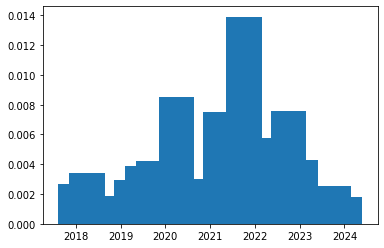

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# graphing_dataset = []
# skipped = 0
# for item in tqdm(total):
#     sentences = item.replace("?", ".").replace("!", ".").split(".")
#     c = []
#     for sentence in sentences:
#         if sentence == "" or sentence == " ":
#             skipped += 1
#             continue
#         try:
#             v = calculate_vector(sentence)
#             c.append(torch.from_numpy(v))
#         except Exception as e:
#             pass
#     graphing_dataset.append(c)

# print(f"Error rate: {(skipped/len(graphing_dataset))*100:.2f}")

vals = []
t_vals = []
i = 0
# m = max(index_chunks)/100
# index_chunk_test = [m*(i+1) for i in range(100)]
for j in range(len(index_chunks)):
    r = 0
    z = 1
    while i < index_chunks[j]:
        i += 1
        for sentence in graphing_dataset[i]:
            z += 1
            x = torch.argmax(nnModel(sentence))
            if x == 0:
                r += 1
    vals.append(r/z)
    t_vals.append(r)


vals = vals[8*4:]
t_vals = t_vals[8*4:]
print(t_vals)
print(vals)
total_t_vals = sum(t_vals)
print([val/total_t_vals for val in t_vals])
plot = plt.bar([2018+(i*0.25) for i in range(len(vals))], [100*(val/total_t_vals) for val in vals])
# for i in range(len(vals)):
#     print(f"{2010+(i*0.25)+2}: {(vals[i]*100):.2f}")
plt.show()
